## TK's simultaneous juxtracellular-imaging recording

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

In [2]:
from keras.layers import RepeatVector, Bidirectional, TimeDistributed
from keras.layers.core import Dropout, Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.utils import plot_model

Using TensorFlow backend.


## Spike vs no-spike Detection

In [3]:
def prepare_sequences(x_train, y_train, window_length):
    full_seq = x_train.flatten()
    target_seq = y_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_seq) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_seq[window_range])
        contain_outlier = target_seq[window_range].sum()>0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), np.array(outliers).astype(np.bool)

In [4]:
def create_lstm_model(hidden_dim, window_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(window_length, 1)))
    model.add(Dropout(p=0.2))
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=False)))
#     model.add(TimeDistributed(Dense(1, activation='linear')))
#     model.compile(loss='mse', optimizer='adam')
    model.add(Dense(1, activation='sigmoid'))    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])  
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [5]:
def tp_fn_fp_tn(expected, actual):
    total = len(expected)
    tp = np.logical_and(expected, actual).sum()
    fn = np.logical_and(~expected, actual).sum()
    fp = np.logical_and(expected, ~actual).sum()
    tn = np.logical_and(~expected, ~actual).sum()
    return tp, fn, fp, tn

In [6]:
dat = np.load('tmpData/ex_spk_voltr.npz')

In [7]:
spkcount, voltr = dat['arr_0'].astype('uint8'), dat['arr_1']

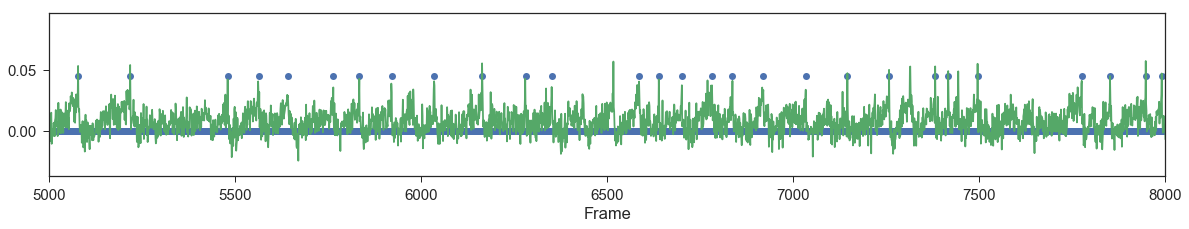

In [8]:
plt.figure(figsize=(20, 3))
plt.plot(spkcount/spkcount.max()*voltr.max(),'o')
plt.plot(voltr)
plt.xlabel('Frame')
plt.xlim([5000, 8000])
plt.show()

In [9]:
window_length = 40
select_only_last_state = False
hidden_dim = 10

x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

In [10]:
m = create_lstm_model(hidden_dim, window_length)
# check of generated model
plot_model(m, 'model.png')
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
# m.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))


pred_x_test = m.predict(x_test)
# tp, fn, fp, tn = tp_fn_fp_tn(pred_x_test, y_test)
# precision = float(tp) / (tp + fp)
# hit_rate = float(tp) / (tp + fn)
# accuracy = float(tp + tn) / (tp + tn + fp + fn)
# print('A good one should have a higher hit rate and higher accuracy')
# print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
##################################
# For autoencoder
# err = x_test - pred_x_test
# abs_err = (err**2).sum(axis=1)
# sns.boxplot(y_test[:, 0], np.sqrt(abs_err.flatten()))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 32576 samples, validate on 3684 samples
Epoch 1/5
32576/32576 [==============================] - 35s 1ms/step - loss: 0.6050 - val_loss: 0.4949
Epoch 2/5
32576/32576 [==============================] - 27s 828us/step - loss: 0.4795 - val_loss: 0.4487
Epoch 3/5
32576/32576 [==============================] - 28s 874us/step - loss: 0.4382 - val_loss: 0.4480
Epoch 4/5
32576/32576 [==============================] - 26s 785us/step - loss: 0.4323 - val_loss: 0.4050
Epoch 5/5
32576/32576 [==============================] - 25s 773us/step - loss: 0.3968 - val_loss: 0.3597


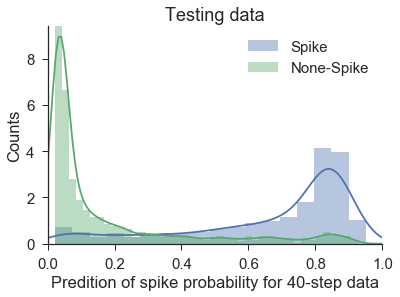

In [11]:
sns.distplot(pred_x_test[y_test[:, 0]], label='Spike')
sns.distplot(pred_x_test[~y_test[:, 0]], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()

Train on 32644 samples, validate on 3616 samples
Epoch 1/5
32644/32644 [==============================] - 42s 1ms/step - loss: 0.5371 - val_loss: 0.4402
Epoch 2/5
32644/32644 [==============================] - 41s 1ms/step - loss: 0.3641 - val_loss: 0.3042
Epoch 3/5
32644/32644 [==============================] - 40s 1ms/step - loss: 0.2950 - val_loss: 0.2957
Epoch 4/5
32644/32644 [==============================] - 40s 1ms/step - loss: 0.2751 - val_loss: 0.2955
Epoch 5/5
32644/32644 [==============================] - 40s 1ms/step - loss: 0.2586 - val_loss: 0.2695


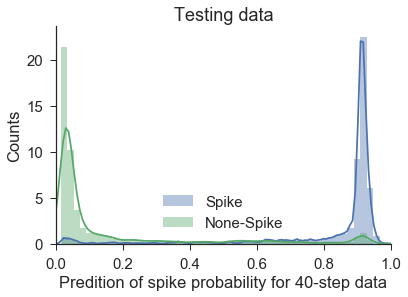

In [12]:
window_length = 40
select_only_last_state = False
hidden_dim = 60

x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]
m = create_lstm_model(hidden_dim, window_length)
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
pred_x_test = m.predict(x_test)
sns.distplot(pred_x_test[y_test[:, 0]], label='Spike')
sns.distplot(pred_x_test[~y_test[:, 0]], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()

## Spike count prediction (not working)

In [13]:
def prepare_sequences_count(x_train, y_train, window_length):
    full_seq = x_train.flatten()
    target_seq = y_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_seq) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_seq[window_range])
        contain_outlier = target_seq[window_range].sum()
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), np.array(outliers)

In [14]:
def create_lstm_model(hidden_dim, window_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(window_length, 1)))
    model.add(Dropout(p=0.2))
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=False)))
    model.add(Dense(1, activation='relu'))    
    model.compile(loss='poisson', optimizer='adam')  
    return model

In [15]:
window_length = 40
select_only_last_state = False
hidden_dim = 60

spkcount[spkcount>1] = 1

x_, contain_outliers_ = prepare_sequences_count(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

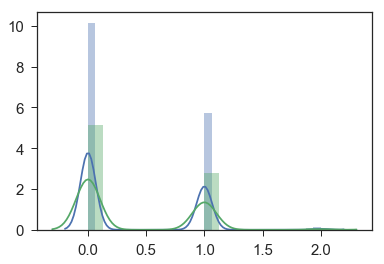

In [16]:
sns.distplot(y_train.flatten())
sns.distplot(y_test.flatten())
plt.show()

Train on 32645 samples, validate on 3615 samples
Epoch 1/5
32645/32645 [==============================] - 44s 1ms/step - loss: 6.0187 - val_loss: 5.9300
Epoch 2/5
32645/32645 [==============================] - 40s 1ms/step - loss: 6.0187 - val_loss: 5.9300
Epoch 3/5
32645/32645 [==============================] - 41s 1ms/step - loss: 6.0187 - val_loss: 5.9300
Epoch 4/5
32645/32645 [==============================] - 36s 1ms/step - loss: 6.0187 - val_loss: 5.9300
Epoch 5/5
32645/32645 [==============================] - 36s 1ms/step - loss: 6.0187 - val_loss: 5.9300


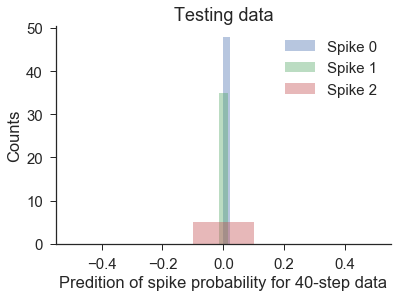

In [17]:
m = create_lstm_model(hidden_dim, window_length)
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
pred_x_test = m.predict(x_test)
for nspk in range(int(y_test.max()+1)):
    if (y_test[:, 0]==nspk).sum()>1:
        sns.distplot(pred_x_test[y_test[:, 0]==nspk], label='Spike %d'%(nspk))
sns.despine()
# plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()

## Spike timing -- sliding maxima

In [18]:
def create_lstm_model(hidden_dim, window_length):
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True), input_shape=(window_length, 1)))
    model.add(Dropout(p=0.2))
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=False)))
    model.add(Dense(1, activation='sigmoid'))    
    model.compile(loss='binary_crossentropy', optimizer='adam')  
    return model

In [19]:
window_length = 40
select_only_last_state = False
hidden_dim = 60

spkcount[spkcount>1] = 1

x_, contain_outliers_ = prepare_sequences(voltr, spkcount, window_length)
train_test_index = np.random.rand(x_.shape[0])>0.1
x_test = x_[~train_test_index, :, :]
y_test = contain_outliers_[~train_test_index][:, np.newaxis]

x_train = x_[train_test_index, :, :]
y_train = contain_outliers_[train_test_index][:, np.newaxis]

Train on 32632 samples, validate on 3628 samples
Epoch 1/5
32632/32632 [==============================] - 39s 1ms/step - loss: 0.5529 - val_loss: 0.4974
Epoch 2/5
32632/32632 [==============================] - 35s 1ms/step - loss: 0.4602 - val_loss: 0.4182
Epoch 3/5
32632/32632 [==============================] - 35s 1ms/step - loss: 0.3434 - val_loss: 0.2862
Epoch 4/5
32632/32632 [==============================] - 35s 1ms/step - loss: 0.2871 - val_loss: 0.2760
Epoch 5/5
32632/32632 [==============================] - 37s 1ms/step - loss: 0.2670 - val_loss: 0.2704


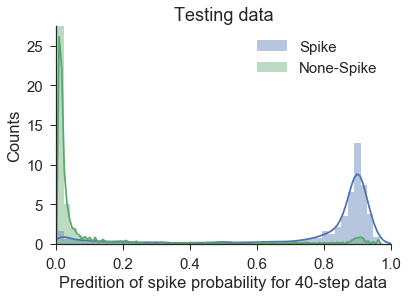

In [20]:
m = create_lstm_model(hidden_dim, window_length)
m.fit(x_train, y_train, batch_size=64, nb_epoch=5, validation_data=(x_test, y_test))
pred_x_test = m.predict(x_test)
sns.distplot(pred_x_test[y_test[:, 0]], label='Spike')
sns.distplot(pred_x_test[~y_test[:, 0]], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.title('Testing data')
plt.show()

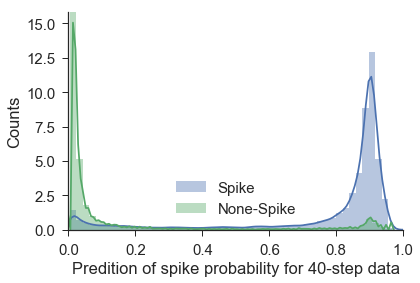

In [21]:
pred_x_test = m.predict(x_)
sns.distplot(pred_x_test[contain_outliers_], label='Spike')
sns.distplot(pred_x_test[~contain_outliers_], label='None-Spike')
sns.despine()
plt.xlim([0,1])
plt.xlabel('Predition of spike probability for 40-step data')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [23]:
pred_x_test = m.predict(x_)
spkInWindow = pred_x_test>0.5
spkInWindow = spkInWindow.flatten()
spkInWindow[:window_length] = False

In [24]:
voltr_ = voltr.copy()
spkcount_ = np.zeros(spkcount.shape)
for idx, nspk in enumerate(spkInWindow):
    if nspk:
        x__ = voltr_[idx:idx+window_length]
        x__ = x__[np.newaxis, :, np.newaxis]
        spk_idx = np.where(x__ == x__.max())[1][0]
        spkcount_[idx+spk_idx] = True

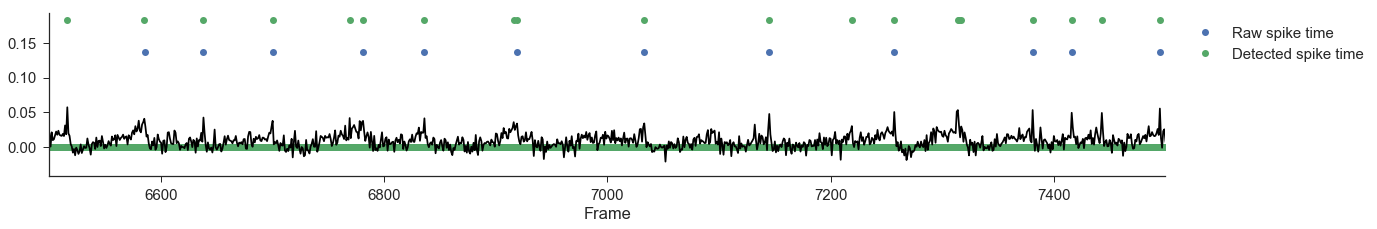

In [25]:
plt.figure(figsize=(20, 3))
plt.plot(spkcount*voltr.max()*1.5,'o', label='Raw spike time')
plt.plot(spkcount_*voltr.max()*2.0,'o', label='Detected spike time')
plt.plot(voltr,'-k')
plt.xlabel('Frame')
plt.xlim([6500, 7500])
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

In [27]:
err = (spkcount != spkcount_).mean()
print('Err rate %f'%(err))

Err rate 0.009367
